# Configurações

In [2]:
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.1/296.1 KB 624.1 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 KB 888.3 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 1.2 MB/s eta 0:00:00a 0:00:01
  Using cached numpy-1.23.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)


In [ ]:
!pip install pandas

In [ ]:
!pip install scikit-learn

# Import's

In [1]:
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from functools import partial

# Código

## Diretórios

In [2]:
DIR = "./" ## Diretório raiz do programa

result_path = "Result/" ## Diretório raiz dos resultados

datasets_path = "Dataset/" ## Diretório raiz dos dataset's

## Leitura dos Resultados

In [3]:
lista_resultados = []
for nome_arquivo in list(filter(lambda x: x.endswith(".json"), os.listdir(DIR+result_path))):
    with open(DIR+result_path+nome_arquivo, "r") as arquivo:
        lista_resultados.append(dict({"name" : nome_arquivo, "data" : json.load(arquivo)}))

In [4]:
lista_resultados

[{'name': 'result_dataset_facebook.json',
  'data': [{'dataset': 'extracao_comentarios_pagina_mbcachacaria.csv',
    'result': [{'text': 'Linda divulgação parabéns amiga 👏',
      'result': {'Negative': 0.011701931245625019,
       'Neutral': 0.06495382636785507,
       'Positive': 0.9233442544937134}},
     {'text': 'Parabéns, muito sucesso 💛',
      'result': {'Negative': 0.011943141929805279,
       'Neutral': 0.05947466567158699,
       'Positive': 0.9285821318626404}},
     {'text': 'Sucesso!!!',
      'result': {'Negative': 0.05442308634519577,
       'Neutral': 0.11043471097946167,
       'Positive': 0.835142195224762}},
     {'text': 'sucesso Amigos queridos.🤗',
      'result': {'Negative': 0.015440459363162518,
       'Neutral': 0.15889042615890503,
       'Positive': 0.8256690502166748}},
     {'text': 'Parabéns pela conquista 😍❤',
      'result': {'Negative': 0.012308136560022831,
       'Neutral': 0.044526729732751846,
       'Positive': 0.943165123462677}},
     {'text': '

## Tratando os resultados

### Métodos Auxiliares

In [5]:
## Método para retornar os resultados de determinado arquivo
def get_data(lista_resultados, nome_arquivo):
    return [x for x in lista_resultados if x["name"] == nome_arquivo][0]

In [6]:
## Classe para fazer estatistica dos resultados
class Estatistica:
    
    def __init__(self, data):
        self._lista_resultados_datasets = data
        self._lista_resultados_totais = self._get_todos_resultados(self._lista_resultados_datasets)
        
    def _get_todos_resultados(self, data):
        lista_resultados_totais = []
        for dataset in data:
            lista_resultados_totais.extend(dataset["result"])
        return lista_resultados_totais
    
    def _contabiliza_resultados(self, data):
        qtd_results = dict({str(x) : 0 for x in data[0]["result"].keys()})
        qtd_results.update(dict({"Unvalued" : 0}))
        for result in data:
            if result["result"]:
                qtd_results[max(result["result"], key=result["result"].get)] += 1
            else:
                qtd_results["Unvalued"] += 1
        qtd_results.update(dict({str(x[0])+"_porcentagem" : x[1]/len(data) for x in qtd_results.items()}))
        return list(qtd_results.items())
            
    def _plot_grafico(self, data, name_dataset = None):
        title = "todos os dados do grupo" if not name_dataset else str("dados do dataset " + str(name_dataset))
        print("Dados brutos " + str(title) + ": " + str(data))
        tipos_resultados = [x[0] for x in data[:4]]
        valores_resultados = [x[1] for x in data[:4]]
        porcentagem = [x[1] for x in data[4:]]
        plt.bar(tipos_resultados, valores_resultados, color = ["#AAAAAA", "#BBBBBB", "#CCCCCC", "#000000"], width = 0.4)
        for i, x in enumerate(porcentagem):
            plt.text(i, valores_resultados[i], f'{str(round(x*100, 3)) + "%"}', ha = 'center')
        plt.xlabel("Tipos de resultados")
        plt.ylabel("Valores dos resultados")
        plt.title(title.title())
        plt.show()
    
    def arruma_dados_twitterASBR(self, dado):
        if dado == '1':
            return "Positive"
        elif dado == '0':
            return "Neutral"
        elif dado == '-1':
            return "Negative"
        return None
    
    def arruma_dados_ecommerce(self, dado):
        if dado == 1.0:
            return "Positive"
        elif dado == 0.0:
            return "Negative"
        return None
    
    def compare_results_with_dataset(self, path_group, neutral = True):
        for dataset in self._lista_resultados_datasets:
            ## Lendo o dataset
            data = pd.read_csv(DIR + datasets_path + path_group + dataset["dataset"], encoding = "utf-8").dropna()
            ################################################
            ## Verifica se existe consistência entre os dados (se é do mesmo tamanho)
            if len(dataset["result"]) != len(data): 
                return "Houve incosistência dos resultados"
            ################################################
            ## Verifica a qual tipo de Dataset pertence, para formatar da forma correta
            if "e-commerce" in path_group:
                metodo_arruma = partial(self.arruma_dados_ecommerce)
                tags = ["review_text", "polarity"]
            elif "twitter_ASBR" in path_group:
                metodo_arruma = partial(self.arruma_dados_twitterASBR)
                tags = ["text", "sentiment"]
            else:
                return "Não existe dados a serem comparados"
            ################################################
            ## Formata os dados da forma correta
            data[tags[1]] = data[tags[1]].apply(metodo_arruma)
            resultados_esperados = data[tags].values.tolist()
            ################################################
            resultados_obtidos = []
            for index in range(len(data)):
                if dataset["result"][index]["text"] == resultados_esperados[index][0]:
                    resultado = None
                    if dataset["result"][index]["result"]:
                        if not neutral:
                            del dataset["result"][index]["result"]["Neutral"]
                        resultado = max(dataset["result"][index]["result"], key=dataset["result"][index]["result"].get)    
                    resultados_obtidos.append([dataset["result"][index]["text"], resultado])
                else:
                    return "Houve incompatibilidade dos resultados"
            ################################################
            indexes = [i for i, x in enumerate(resultados_esperados) if x[1] is None]
            indexes += [i for i, x in enumerate(resultados_obtidos) if x[1] is None]
            resultados_esperados = [x[1] for i, x in enumerate(resultados_esperados) if i not in indexes]
            resultados_obtidos = [x[1] for i, x in enumerate(resultados_obtidos) if i not in indexes]
            print("Resultado do dataset:\n")
            print("Matriz de confusão:\n")
            print(metrics.confusion_matrix(resultados_esperados, resultados_obtidos))
            print("Metricas:")
            print(metrics.classification_report(resultados_esperados, resultados_obtidos, digits=3))
    
    @property
    def grafico_resultados_dataset(self):
        cont_resultados = []
        for dataset in self._lista_resultados_datasets:
            cont_resultados.append((dataset["dataset"], self._contabiliza_resultados(dataset["result"])))
        for data in cont_resultados:
            self._plot_grafico(data[1], data[0])
    
    @property
    def grafico_resultados_totais(self):
        self._plot_grafico(self._contabiliza_resultados(self._lista_resultados_totais))
    
    @property
    def resultados_totais(self):
        return self._lista_resultados_totais
    

### Tratando resultados do Facebook

#### Pegando os resultados do Facebook

In [7]:
data = get_data(lista_resultados, "result_dataset_facebook.json")

#### Estatística do Facebook

In [8]:
estatistica = Estatistica(data)

Dados brutos todos os dados do grupo: [('Negative', 3319), ('Neutral', 17712), ('Positive', 13589), ('Unvalued', 0), ('Negative_porcentagem', 0.09586943963027152), ('Neutral_porcentagem', 0.5116117850953206), ('Positive_porcentagem', 0.39251877527440787), ('Unvalued_porcentagem', 0.0)]


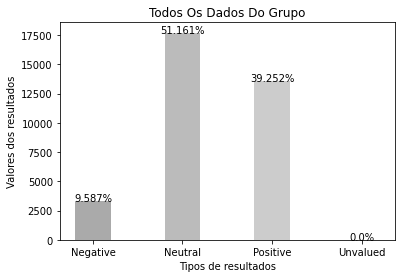

In [9]:
estatistica.grafico_resultados_totais

Dados brutos dados do dataset extracao_comentarios_pagina_mbcachacaria.csv: [('Negative', 0), ('Neutral', 1), ('Positive', 18), ('Unvalued', 0), ('Negative_porcentagem', 0.0), ('Neutral_porcentagem', 0.05263157894736842), ('Positive_porcentagem', 0.9473684210526315), ('Unvalued_porcentagem', 0.0)]


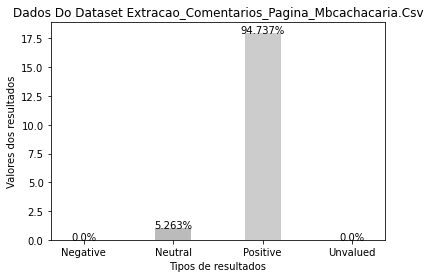

Dados brutos dados do dataset extracao_comentarios_pagina_cachacarianacional.csv: [('Positive', 4400), ('Negative', 1586), ('Neutral', 8543), ('Unvalued', 0), ('Positive_porcentagem', 0.30284259068070757), ('Negative_porcentagem', 0.1091609883680914), ('Neutral_porcentagem', 0.5879964209512011), ('Unvalued_porcentagem', 0.0)]


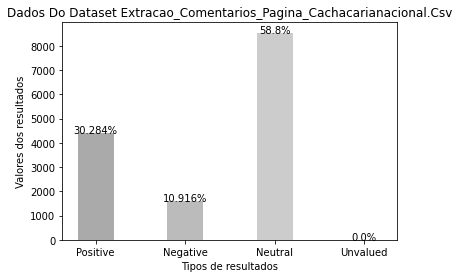

Dados brutos dados do dataset extracao_comentarios_pagina_lojacachacaepinga.csv: [('Positive', 17), ('Negative', 2), ('Neutral', 30), ('Unvalued', 0), ('Positive_porcentagem', 0.3469387755102041), ('Negative_porcentagem', 0.04081632653061224), ('Neutral_porcentagem', 0.6122448979591837), ('Unvalued_porcentagem', 0.0)]


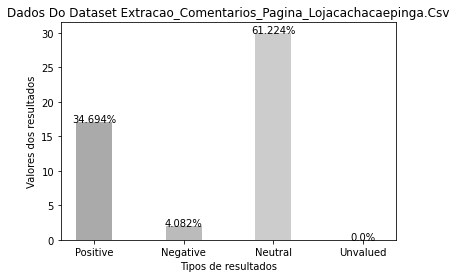

Dados brutos dados do dataset extracao_comentarios_pagina_blubeer.com.br.csv: [('Negative', 4), ('Neutral', 28), ('Positive', 28), ('Unvalued', 0), ('Negative_porcentagem', 0.06666666666666667), ('Neutral_porcentagem', 0.4666666666666667), ('Positive_porcentagem', 0.4666666666666667), ('Unvalued_porcentagem', 0.0)]


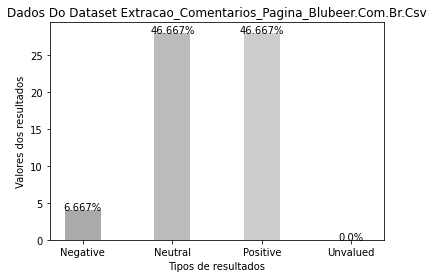

Dados brutos dados do dataset extracao_comentarios_pagina_brme.oficial.csv: [('Negative', 2), ('Neutral', 1), ('Positive', 2), ('Unvalued', 0), ('Negative_porcentagem', 0.4), ('Neutral_porcentagem', 0.2), ('Positive_porcentagem', 0.4), ('Unvalued_porcentagem', 0.0)]


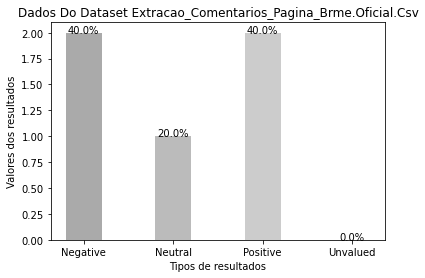

Dados brutos dados do dataset extracao_comentarios_pagina_araraunacachacaria.csv: [('Negative', 10), ('Neutral', 73), ('Positive', 114), ('Unvalued', 0), ('Negative_porcentagem', 0.050761421319796954), ('Neutral_porcentagem', 0.37055837563451777), ('Positive_porcentagem', 0.5786802030456852), ('Unvalued_porcentagem', 0.0)]


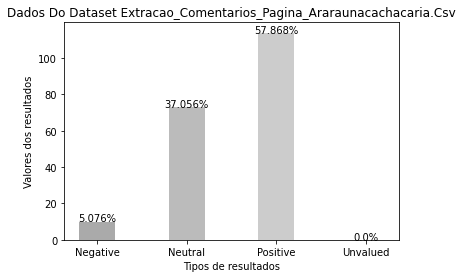

Dados brutos dados do dataset extracao_comentarios_pagina_magnificadefaria.csv: [('Positive', 636), ('Negative', 46), ('Neutral', 176), ('Unvalued', 0), ('Positive_porcentagem', 0.7412587412587412), ('Negative_porcentagem', 0.053613053613053616), ('Neutral_porcentagem', 0.20512820512820512), ('Unvalued_porcentagem', 0.0)]


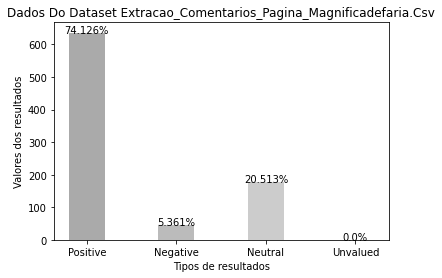

Dados brutos dados do dataset extracao_comentarios_pagina_wibacachaca.csv: [('Negative', 71), ('Positive', 846), ('Neutral', 270), ('Unvalued', 0), ('Negative_porcentagem', 0.05981465880370682), ('Positive_porcentagem', 0.7127211457455771), ('Neutral_porcentagem', 0.22746419545071608), ('Unvalued_porcentagem', 0.0)]


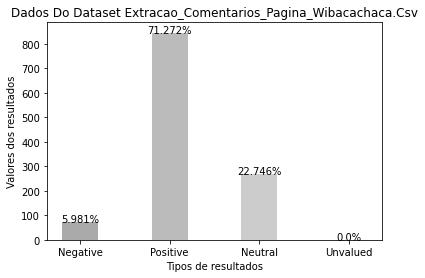

Dados brutos dados do dataset extracao_comentarios_pagina_amburanabr.csv: [('Negative', 61), ('Positive', 326), ('Neutral', 458), ('Unvalued', 0), ('Negative_porcentagem', 0.07218934911242604), ('Positive_porcentagem', 0.3857988165680473), ('Neutral_porcentagem', 0.5420118343195266), ('Unvalued_porcentagem', 0.0)]


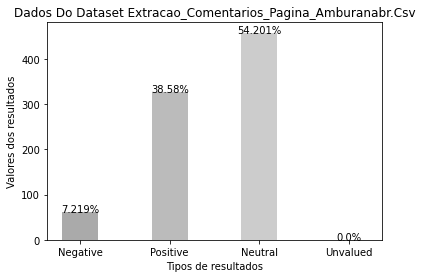

Dados brutos dados do dataset extracao_comentarios_pagina_cachacasapucaia.csv: [('Negative', 15), ('Neutral', 121), ('Positive', 194), ('Unvalued', 0), ('Negative_porcentagem', 0.045454545454545456), ('Neutral_porcentagem', 0.36666666666666664), ('Positive_porcentagem', 0.5878787878787879), ('Unvalued_porcentagem', 0.0)]


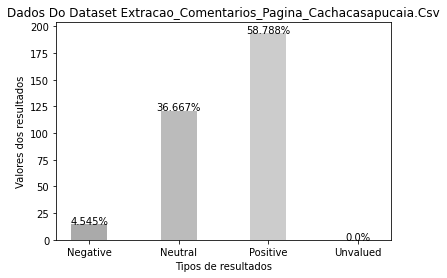

Dados brutos dados do dataset extracao_comentarios_pagina_cachacariasalinas.com.br.csv: [('Negative', 45), ('Neutral', 464), ('Positive', 369), ('Unvalued', 0), ('Negative_porcentagem', 0.05125284738041002), ('Neutral_porcentagem', 0.5284738041002278), ('Positive_porcentagem', 0.4202733485193622), ('Unvalued_porcentagem', 0.0)]


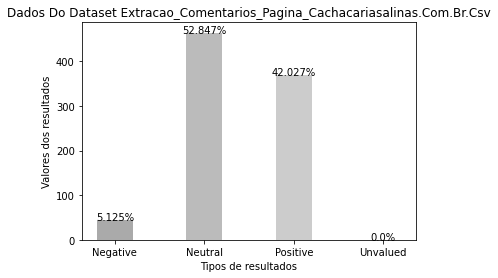

Dados brutos dados do dataset extracao_comentarios_pagina_cachacavelhobarreirooficial.csv: [('Neutral', 403), ('Negative', 59), ('Positive', 196), ('Unvalued', 0), ('Neutral_porcentagem', 0.6124620060790273), ('Negative_porcentagem', 0.08966565349544073), ('Positive_porcentagem', 0.2978723404255319), ('Unvalued_porcentagem', 0.0)]


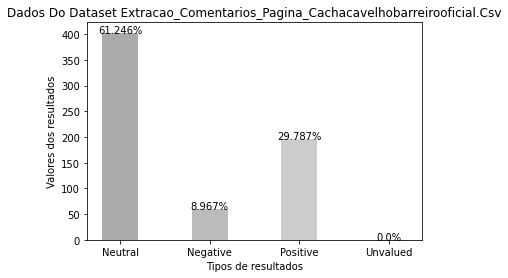

Dados brutos dados do dataset extracao_comentarios_pagina_cachacasbrasileirasoficial.csv: [('Negative', 2), ('Positive', 30), ('Neutral', 76), ('Unvalued', 0), ('Negative_porcentagem', 0.018518518518518517), ('Positive_porcentagem', 0.2777777777777778), ('Neutral_porcentagem', 0.7037037037037037), ('Unvalued_porcentagem', 0.0)]


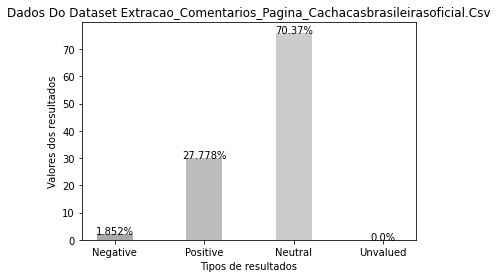

Dados brutos dados do dataset extracao_comentarios_pagina_bebidaonline.csv: [('Positive', 1), ('Negative', 1), ('Neutral', 4), ('Unvalued', 0), ('Positive_porcentagem', 0.16666666666666666), ('Negative_porcentagem', 0.16666666666666666), ('Neutral_porcentagem', 0.6666666666666666), ('Unvalued_porcentagem', 0.0)]


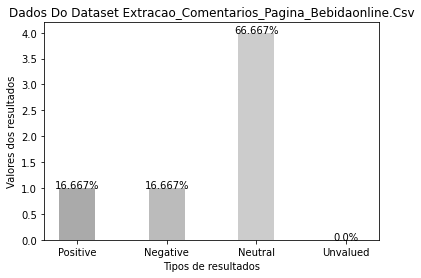

Dados brutos dados do dataset extracao_comentarios_pagina_domtapparoengenho.csv: [('Positive', 2257), ('Negative', 839), ('Neutral', 3077), ('Unvalued', 0), ('Positive_porcentagem', 0.36562449376316214), ('Negative_porcentagem', 0.13591446622387818), ('Neutral_porcentagem', 0.49846104001295966), ('Unvalued_porcentagem', 0.0)]


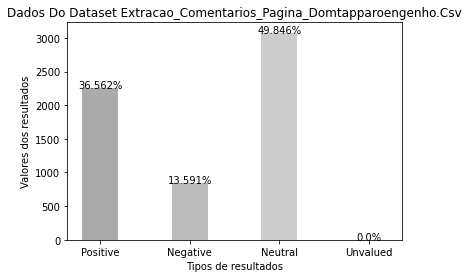

Dados brutos dados do dataset extracao_comentarios_pagina_Sanhacu.csv: [('Negative', 174), ('Neutral', 629), ('Positive', 1820), ('Unvalued', 0), ('Negative_porcentagem', 0.06633625619519634), ('Neutral_porcentagem', 0.23980175371711782), ('Positive_porcentagem', 0.6938619900876859), ('Unvalued_porcentagem', 0.0)]


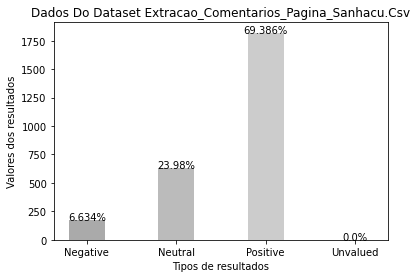

Dados brutos dados do dataset extracao_comentarios_pagina_CachacaCompanheira.csv: [('Negative', 289), ('Neutral', 2788), ('Positive', 1921), ('Unvalued', 0), ('Negative_porcentagem', 0.05782312925170068), ('Neutral_porcentagem', 0.5578231292517006), ('Positive_porcentagem', 0.3843537414965986), ('Unvalued_porcentagem', 0.0)]


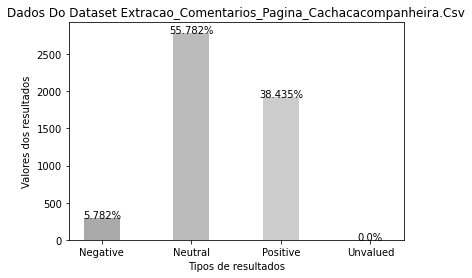

Dados brutos dados do dataset extracao_comentarios_pagina_casadabebida.csv: [('Positive', 206), ('Neutral', 399), ('Negative', 85), ('Unvalued', 0), ('Positive_porcentagem', 0.2985507246376812), ('Neutral_porcentagem', 0.5782608695652174), ('Negative_porcentagem', 0.12318840579710146), ('Unvalued_porcentagem', 0.0)]


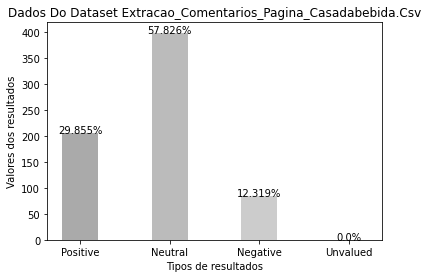

Dados brutos dados do dataset extracao_comentarios_pagina_cachacaepresente.csv: [('Negative', 28), ('Neutral', 171), ('Positive', 208), ('Unvalued', 0), ('Negative_porcentagem', 0.0687960687960688), ('Neutral_porcentagem', 0.4201474201474201), ('Positive_porcentagem', 0.5110565110565111), ('Unvalued_porcentagem', 0.0)]


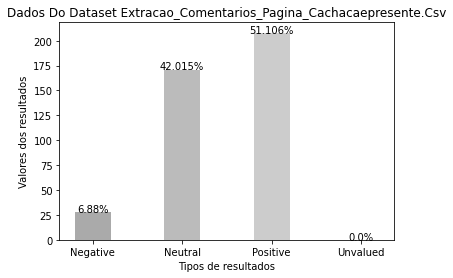

In [10]:
estatistica.grafico_resultados_dataset

In [11]:
estatistica.compare_results_with_dataset("dataset_facebook/")

'Não existe dados a serem comparados'

### Tratando resultados do Twitter ASBR

#### Pegando os resultados do Twitter ASBR

In [12]:
data = get_data(lista_resultados, "result_dataset_twitter_ASBR.json")

#### Estatística do Twitter ASBR

In [13]:
estatistica = Estatistica(data)

Dados brutos todos os dados do grupo: [('Negative', 5505), ('Neutral', 4151), ('Positive', 5179), ('Unvalued', 0), ('Negative_porcentagem', 0.3710819009100101), ('Neutral_porcentagem', 0.27981125716211663), ('Positive_porcentagem', 0.3491068419278733), ('Unvalued_porcentagem', 0.0)]


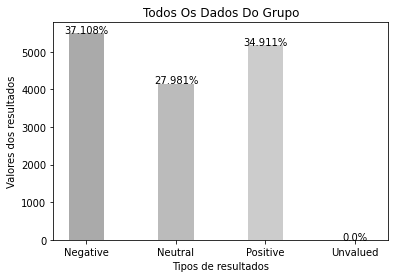

In [14]:
estatistica.grafico_resultados_totais

Dados brutos dados do dataset dataset_twitter_ASBR.csv: [('Negative', 5505), ('Neutral', 4151), ('Positive', 5179), ('Unvalued', 0), ('Negative_porcentagem', 0.3710819009100101), ('Neutral_porcentagem', 0.27981125716211663), ('Positive_porcentagem', 0.3491068419278733), ('Unvalued_porcentagem', 0.0)]


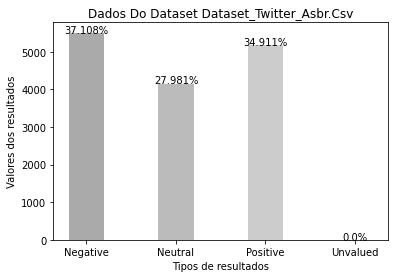

In [15]:
estatistica.grafico_resultados_dataset

In [16]:
estatistica.compare_results_with_dataset("dataset_twitter_ASBR/")

Resultado do dataset:

Matriz de confusão:

[[3528  668  208]
 [1146 2213  426]
 [ 809 1254 4536]]
Metricas:
              precision    recall  f1-score   support

    Negative      0.643     0.801     0.714      4404
     Neutral      0.535     0.585     0.559      3785
    Positive      0.877     0.687     0.771      6599

    accuracy                          0.695     14788
   macro avg      0.685     0.691     0.681     14788
weighted avg      0.720     0.695     0.700     14788



### Tratando resultados do Twitter

#### Pegando os resultados do Twitter

In [17]:
data = get_data(lista_resultados, "result_dataset_twitter.json")

#### Estatística do Twitter

In [18]:
estatistica = Estatistica(data)

Dados brutos todos os dados do grupo: [('Positive', 1853), ('Negative', 1071), ('Neutral', 4849), ('Unvalued', 0), ('Positive_porcentagem', 0.2383892962820018), ('Negative_porcentagem', 0.13778463913546893), ('Neutral_porcentagem', 0.6238260645825293), ('Unvalued_porcentagem', 0.0)]


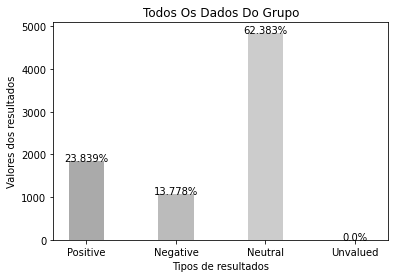

In [19]:
estatistica.grafico_resultados_totais

Dados brutos dados do dataset teste_sentimentos.csv: [('Positive', 1853), ('Negative', 1071), ('Neutral', 4849), ('Unvalued', 0), ('Positive_porcentagem', 0.2383892962820018), ('Negative_porcentagem', 0.13778463913546893), ('Neutral_porcentagem', 0.6238260645825293), ('Unvalued_porcentagem', 0.0)]


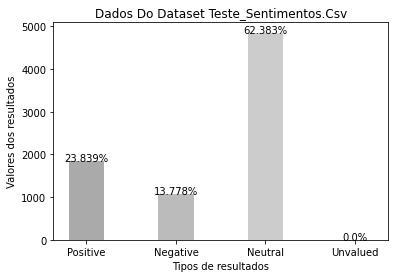

In [20]:
estatistica.grafico_resultados_dataset

In [21]:
estatistica.compare_results_with_dataset("dataset_twitter/")

'Não existe dados a serem comparados'

### Tratando resultados do e-commerce

#### Pegando os resultados do e-commerce

In [22]:
data = get_data(lista_resultados, "result_dataset_e-commerce.json")

#### Estatística do e-commerce

In [23]:
estatistica = Estatistica(data)

Dados brutos todos os dados do grupo: [('Negative', 604661), ('Neutral', 272994), ('Positive', 1500531), ('Unvalued', 7976), ('Negative_porcentagem', 0.2534031637416068), ('Neutral_porcentagem', 0.11440715257388225), ('Positive_porcentagem', 0.6288470774406767), ('Unvalued_porcentagem', 0.003342606243834241)]


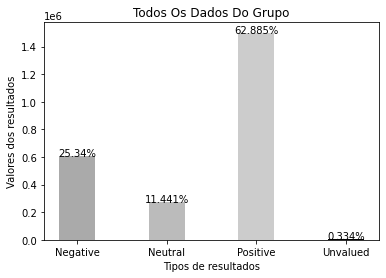

In [24]:
estatistica.grafico_resultados_totais

Dados brutos dados do dataset utlc_movies.csv: [('Negative', 282320), ('Neutral', 139004), ('Positive', 760424), ('Unvalued', 7794), ('Negative_porcentagem', 0.2373350415538081), ('Neutral_porcentagem', 0.1168550585015073), ('Positive_porcentagem', 0.6392577983795444), ('Unvalued_porcentagem', 0.006552101565140197)]


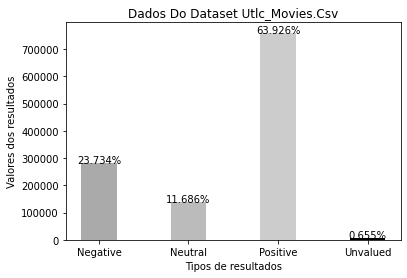

Dados brutos dados do dataset buscape.csv: [('Negative', 10208), ('Neutral', 10194), ('Positive', 53080), ('Unvalued', 144), ('Negative_porcentagem', 0.13864667372938907), ('Neutral_porcentagem', 0.13845652351071633), ('Positive_porcentagem', 0.7209409719392605), ('Unvalued_porcentagem', 0.001955830820634015)]


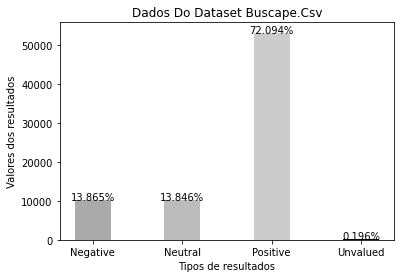

Dados brutos dados do dataset b2w.csv: [('Negative', 33474), ('Neutral', 11716), ('Positive', 70838), ('Unvalued', 30), ('Negative_porcentagem', 0.28842475314067106), ('Neutral_porcentagem', 0.10094952523738131), ('Positive_porcentagem', 0.6103672301780144), ('Unvalued_porcentagem', 0.0002584914439332058)]


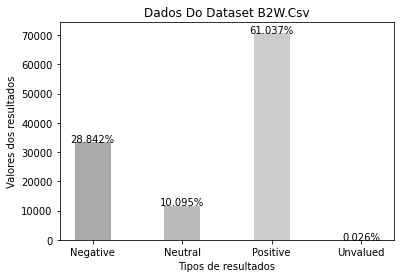

Dados brutos dados do dataset utlc_apps.csv: [('Negative', 269734), ('Neutral', 103725), ('Positive', 595391), ('Unvalued', 8), ('Negative_porcentagem', 0.27840405921197947), ('Neutral_porcentagem', 0.10705903238658297), ('Positive_porcentagem', 0.6145286512574598), ('Unvalued_porcentagem', 8.257143977755254e-06)]


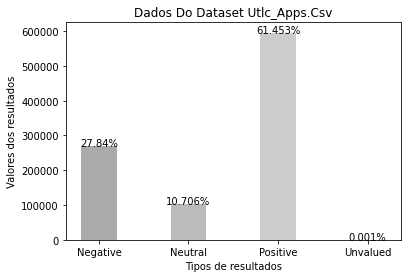

Dados brutos dados do dataset olist.csv: [('Negative', 8925), ('Neutral', 8355), ('Positive', 20798), ('Unvalued', 0), ('Negative_porcentagem', 0.2343873102578917), ('Neutral_porcentagem', 0.21941803666158938), ('Positive_porcentagem', 0.546194653080519), ('Unvalued_porcentagem', 0.0)]


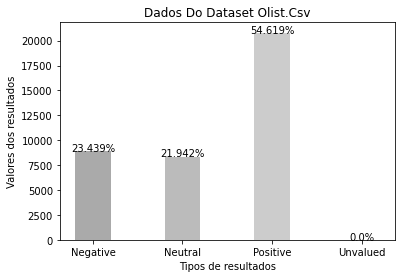

In [25]:
estatistica.grafico_resultados_dataset

In [26]:
estatistica.compare_results_with_dataset("dataset_e-commerce/", False)

Resultado do dataset:

Matriz de confusão:

[[101393  35221]
 [264386 780748]]
Metricas:
              precision    recall  f1-score   support

    Negative      0.277     0.742     0.404    136614
    Positive      0.957     0.747     0.839   1045134

    accuracy                          0.746   1181748
   macro avg      0.617     0.745     0.621   1181748
weighted avg      0.878     0.746     0.789   1181748

Resultado do dataset:

Matriz de confusão:

[[ 5429  1351]
 [ 9933 56769]]
Metricas:
              precision    recall  f1-score   support

    Negative      0.353     0.801     0.490      6780
    Positive      0.977     0.851     0.910     66702

    accuracy                          0.846     73482
   macro avg      0.665     0.826     0.700     73482
weighted avg      0.919     0.846     0.871     73482

Resultado do dataset:

Matriz de confusão:

[[34068  1671]
 [ 6819 73470]]
Metricas:
              precision    recall  f1-score   support

    Negative      0.833     0.95

## Testes

In [ ]:
import pandas as pd

In [ ]:
dataset = "b2w.csv"
tag = ["review_text", "polarity"]

In [ ]:
df = pd.read_csv("./Dataset/dataset_e-commerce/" + str(dataset), encoding = "utf-8")

In [ ]:
df[tag[1]]

In [ ]:
def arruma_dados_ecommerce(dado):
    if dado == 1.0:
        return "Positive"
    if dado == 0.0:
        return "Negative"
    return None

In [ ]:
df[tag[1]] = df[tag[1]].apply(arruma_dados_ecommerce)

In [ ]:
dado = df[tag].values.tolist()

In [ ]:
dado

In [ ]:
teste = [2,4,6,5,1,3,5]
index = [0,1,4]
teste = [x for i, x in enumerate(teste) if i not in index]

In [ ]:
teste

OBS: Tomando como exemplo o caso binário de positivo e negativo.

link: https://towardsdatascience.com/multi-class-metrics-made-simple-part-i-precision-and-recall-9250280bddc2

## Metricas:
Matriz de confusão, é uma matriz quadrada, que armazerna os rotulos e se estão rotulados de maneira esperada.
- TP: True Positive - Quando acerta o rotulo
- FP: False Positive - Quando erra o rotulo
- TN: True Negative - Quando acerta não rotulando
- FN: False Negative - Quando erra não rotulando

### Precision: 
precisão responde à seguinte pergunta: qual proporção de Positivos previstos é verdadeiramente Positivo?

TP / (TP + FP)

### Recal:
recall responde à seguinte pergunta: qual proporção de Positivos reais é classificada corretamente?

TP / (TP + FN)

### F1-score:
F1-score média harmônica entre Precisão e o recall

2 x (precision x recall) / (precision + recall)

### Accuracy e MicroF1: 
Acurácia responde á seguinte pergunta: qual proporção dos rotulos foram rotulados corretamente?

(TP + TN) / (TP + TN + FP + FN)

### MacroF1: